In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten

from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array

### Config

In [2]:
train_meta_data = '../train.csv'
train_data_dir = '../input/paddy-disease-classification/train_images'
epochs = 100
lr = 1e-3
valid_split = 0.2
input_size = 224
batch_size = 32
classes = 10
initializer = tf.keras.initializers.HeUniform()
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
loss = tf.keras.losses.categorical_crossentropy

In [3]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=20,
                                              monitor='val_loss',
                                              restore_best_weights=True,
                                              verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=3,
                                                 monitor='val_loss',
                                                 factor=0.01,
                                                 verbose=1)

### Inception v1.0

In [4]:
def inception(x, filters, projection, init=initializer, name=None):
    f_1x1, f_3x3, f_3x3_reduce, f_5x5, f_5x5_reduce = filters
    x1 = Conv2D(filters=f_1x1,
                kernel_size=(1, 1),
                kernel_initializer=init,
                strides=(1, 1),
                activation=relu,
                padding='same')(x)
    x3_reducer = Conv2D(filters=f_3x3_reduce,
                        kernel_size=(1, 1),
                        kernel_initializer=init,
                        strides=(1, 1),
                        activation=relu,
                        padding='same')(x)
    x5_reducer = Conv2D(filters=f_5x5_reduce,
                        kernel_size=(1, 1),
                        kernel_initializer=init,
                        strides=(1, 1),
                        activation=relu,
                        padding='same')(x)
    pool = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x)

    x3 = Conv2D(filters=f_3x3,
                kernel_size=(3, 3),
                kernel_initializer=init,
                strides=(1, 1),
                activation=relu,
                padding='same')(x3_reducer)
    x5 = Conv2D(filters=f_5x5,
                kernel_size=(5, 5),
                kernel_initializer=init,
                strides=(1, 1),
                activation=relu,
                padding='same')(x5_reducer)
    proj = Conv2D(filters=projection,
                  kernel_size=(1, 1),
                  kernel_initializer=init,
                  strides=(1, 1),
                  activation=relu,
                  padding='same')(pool)

    x = concatenate([x1, x3, x5, proj], axis=3, name=name)

    return x


def model_builder(shape, classes):
    input_layer = Input(shape=shape)
    x = Conv2D(filters=64, kernel_size=(7, 7), kernel_initializer=initializer, strides=(2, 2), activation=relu,
               padding='same')(input_layer)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=64, kernel_size=(1, 1), strides=(1, 1), activation=relu, padding='same')(x)
    x = Conv2D(filters=192, kernel_size=(3, 3), strides=(1, 1), activation=relu, padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = inception(x, [64, 128, 96, 32, 16], projection=32, name='inception_3a')
    x = inception(x, [128, 192, 128, 96, 32], projection=64, name='inception_3b')
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
#     x = inception(x, [192, 208, 96, 48, 16], projection=64, name='inception_4a')

    # auxiliary path 1
    aux_1 = AveragePooling2D(pool_size=(5, 5), strides=(3, 3), padding='valid')(x)
    aux_1 = Conv2D(filters=128, kernel_size=(1, 1), kernel_initializer=initializer, strides=(1, 1), activation=relu,
                   padding='valid')(aux_1)
    aux_1 = Dense(units=1024, activation=relu)(aux_1)
    aux_1 = Dropout(rate=0.7)(aux_1)
    aux_1 = GlobalAveragePooling2D()(aux_1)
    aux_out1 = Dense(units=classes, activation=softmax, name='aux_out1')(aux_1)

    x = inception(x, [160, 224, 112, 64, 24], projection=64, name='inception_4b')
    x = inception(x, [128, 256, 128, 64, 24], projection=64, name='inception_4c')
#     x = inception(x, [112, 288, 144, 64, 32], projection=64, name='inception_4d')
#     x = inception(x, [256, 320, 160, 128, 32], projection=128, name='inception_4e')

    # auxiliary path 2
    aux_2 = AveragePooling2D(pool_size=(5, 5), strides=(3, 3), padding='valid')(x)
    aux_2 = Conv2D(filters=128, kernel_size=(1, 1), kernel_initializer=initializer, strides=(1, 1), activation=relu,
                   padding='valid')(aux_2)
    aux_2 = Dense(units=1024, activation=relu)(aux_2)
    aux_2 = Dropout(rate=0.7)(aux_2)
    aux_2 = GlobalAveragePooling2D()(aux_2)
    aux_out2 = Dense(units=classes, activation=softmax, name='aux_out2')(aux_2)

    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = inception(x, [256, 320, 160, 128, 32], projection=128, name='inception_5a')
    x = inception(x, [384, 384, 192, 128, 48], projection=128, name='inception_5b')
    x = AveragePooling2D(pool_size=(7, 7), strides=(1, 1))(x)
    x = Dropout(rate=0.4)(x)
    x = GlobalAveragePooling2D()(x)
    output_layer = Dense(units=classes, activation=softmax, name='main_out')(x)

    model = Model(input_layer, [output_layer, aux_out1, aux_out2])
    model.compile(optimizer=optimizer,
                  loss=loss,
                  loss_weights={'main_out': 1, 'aux_out1': 0.3, 'aux_out2': 0.3},
                  metrics=['accuracy'])

    return model

### Config data loaders

In [5]:
generator = ImageDataGenerator(rescale=1 / 255,
                               rotation_range=20,
                               brightness_range=(1,1.5),
                               zoom_range=0.3,
                               horizontal_flip=True,
                               vertical_flip=True,
                               validation_split=valid_split)

train_data = generator.flow_from_directory(directory=train_data_dir,
                                           target_size=(input_size, input_size),
                                           batch_size=batch_size,
                                           subset='training')

valid_data = generator.flow_from_directory(directory=train_data_dir,
                                           target_size=(input_size, input_size),
                                           subset='validation')

Found 8330 images belonging to 10 classes.
Found 2077 images belonging to 10 classes.


In [6]:
len(train_data.next()[0]), len(valid_data.next()[0])

(32, 32)

### Model

In [7]:
model = model_builder(shape=(input_size, input_size, 3), classes=classes)

2022-06-22 04:38:14.036115: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-22 04:38:14.176536: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-22 04:38:14.177813: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-22 04:38:14.179982: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 56, 56, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 56, 56, 64)   256         max_pooling2d[0][0]              
______________________________________________________________________________________________

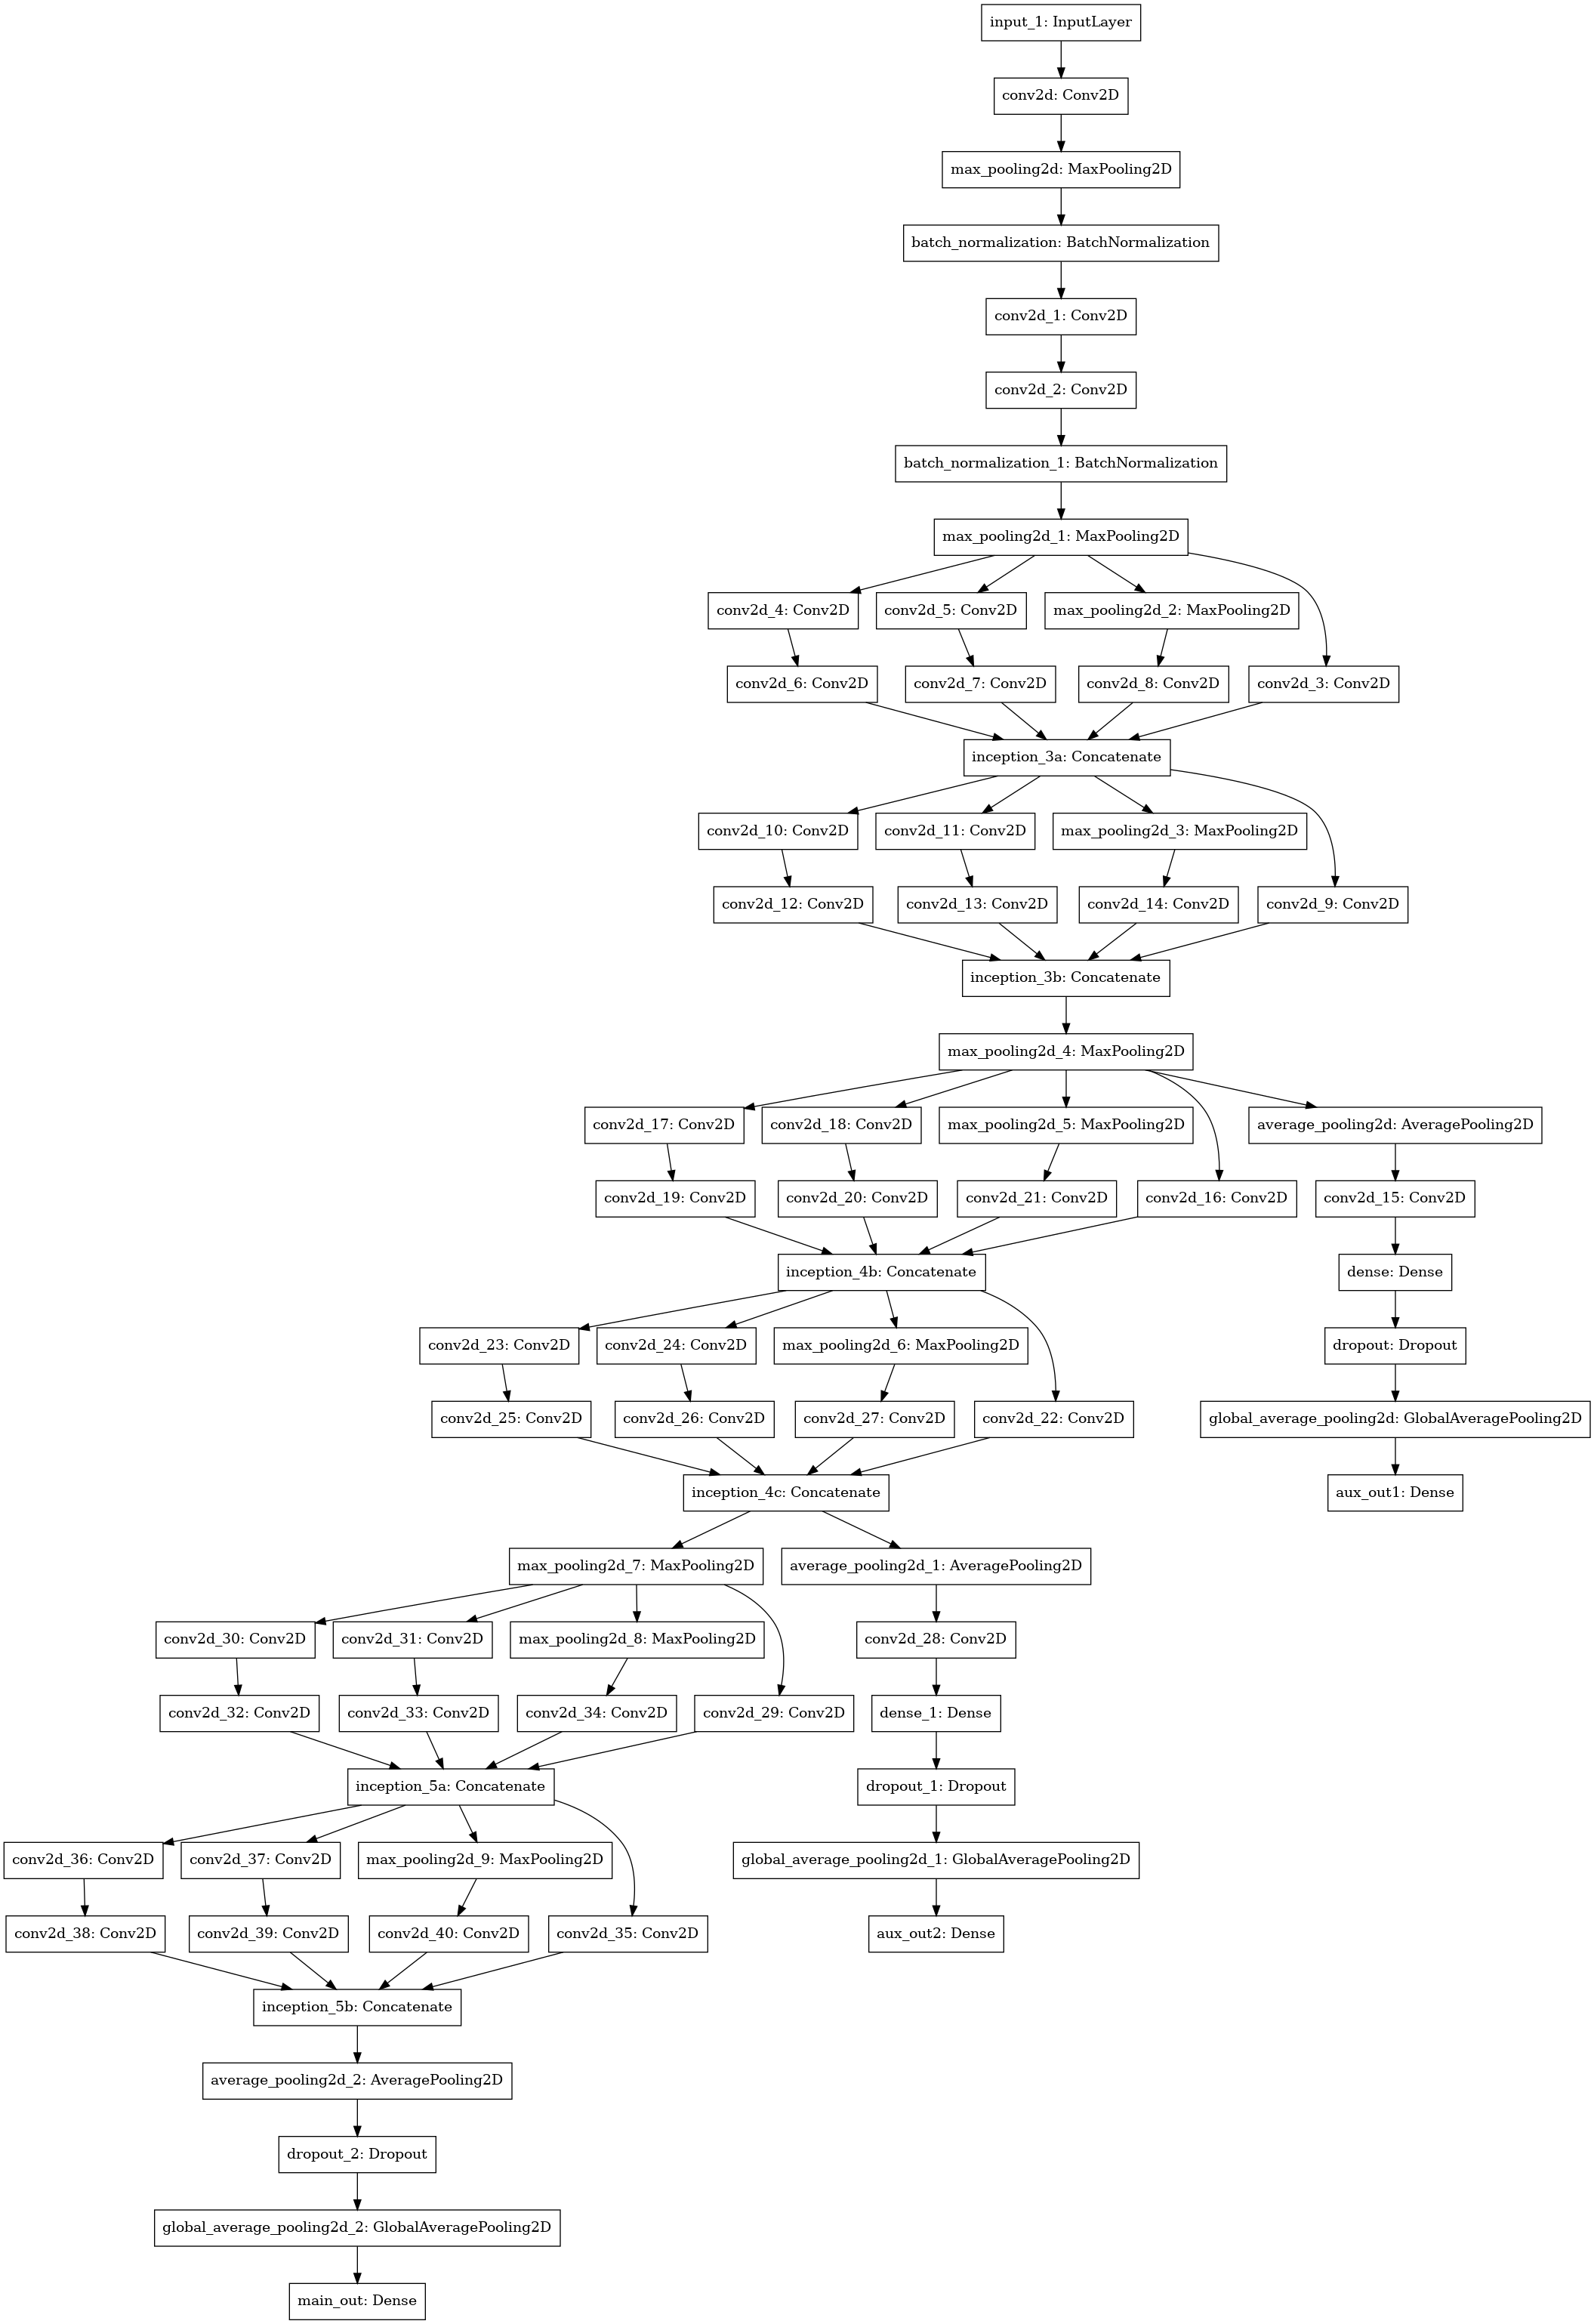

In [9]:
tf.keras.utils.plot_model(model, 'baseline_inception.png')

In [10]:
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=epochs,
                    callbacks=[early_stop])

2022-06-22 04:38:20.118533: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-06-22 04:38:26.164349: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


261/261 [==============================] - 273s 1s/step - loss: 3.5997 - main_out_loss: 2.3735 - aux_out1_loss: 2.0286 - aux_out2_loss: 2.0587 - main_out_accuracy: 0.2460 - aux_out1_accuracy: 0.2667 - aux_out2_accuracy: 0.2537 - val_loss: 3.2853 - val_main_out_loss: 2.0454 - val_aux_out1_loss: 2.0743 - val_aux_out2_loss: 2.0588 - val_main_out_accuracy: 0.2350 - val_aux_out1_accuracy: 0.2773 - val_aux_out2_accuracy: 0.2561
Epoch 2/100
261/261 [==============================] - 201s 771ms/step - loss: 2.8940 - main_out_loss: 1.8168 - aux_out1_loss: 1.7837 - aux_out2_loss: 1.8069 - main_out_accuracy: 0.3616 - aux_out1_accuracy: 0.3679 - aux_out2_accuracy: 0.3619 - val_loss: 3.3400 - val_main_out_loss: 2.0366 - val_aux_out1_loss: 2.2346 - val_aux_out2_loss: 2.1103 - val_main_out_accuracy: 0.2831 - val_aux_out1_accuracy: 0.2590 - val_aux_out2_accuracy: 0.2687
Epoch 3/100
261/261 [==============================] - 198s 760ms/step - loss: 2.6161 - main_out_loss: 1.6389 - aux_out1_loss: 1.6174

### Evaluate

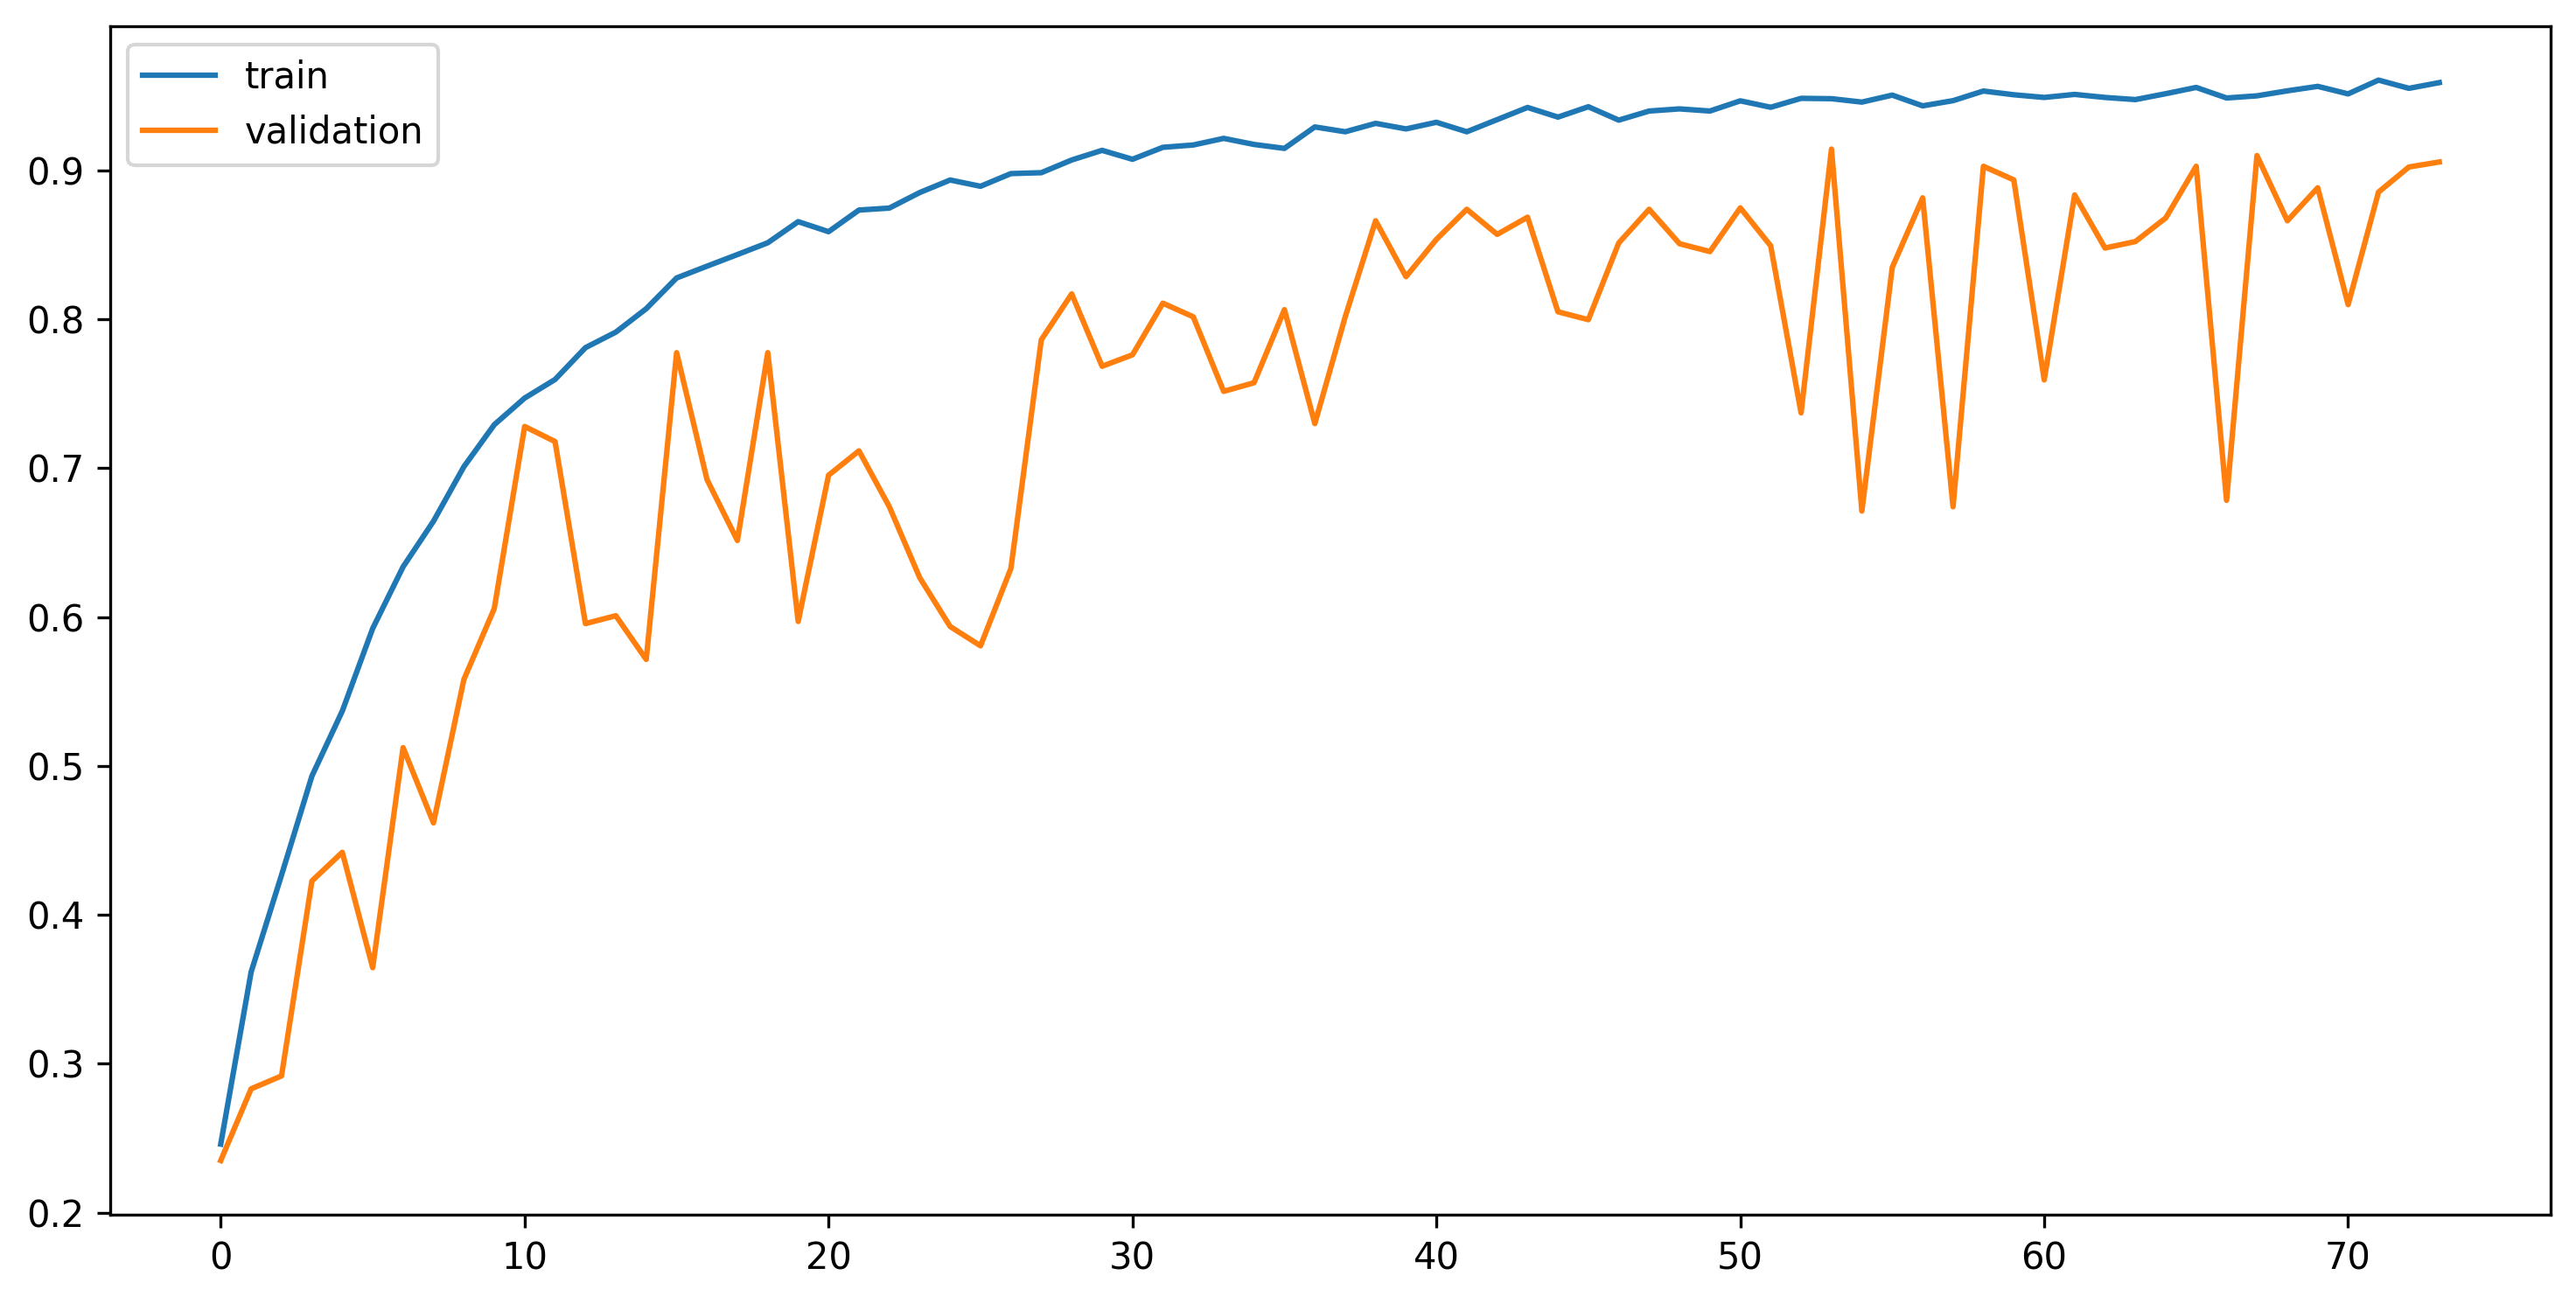

In [11]:
plt.figure(figsize=[12,6], dpi=300)
sns.lineplot(x=list(range(len(history.history['main_out_accuracy']))),
             y=history.history['main_out_accuracy'],
             label='train')
sns.lineplot(x=list(range(len(history.history['val_main_out_accuracy']))),
             y=history.history['val_main_out_accuracy'],
             label='validation')
plt.show()

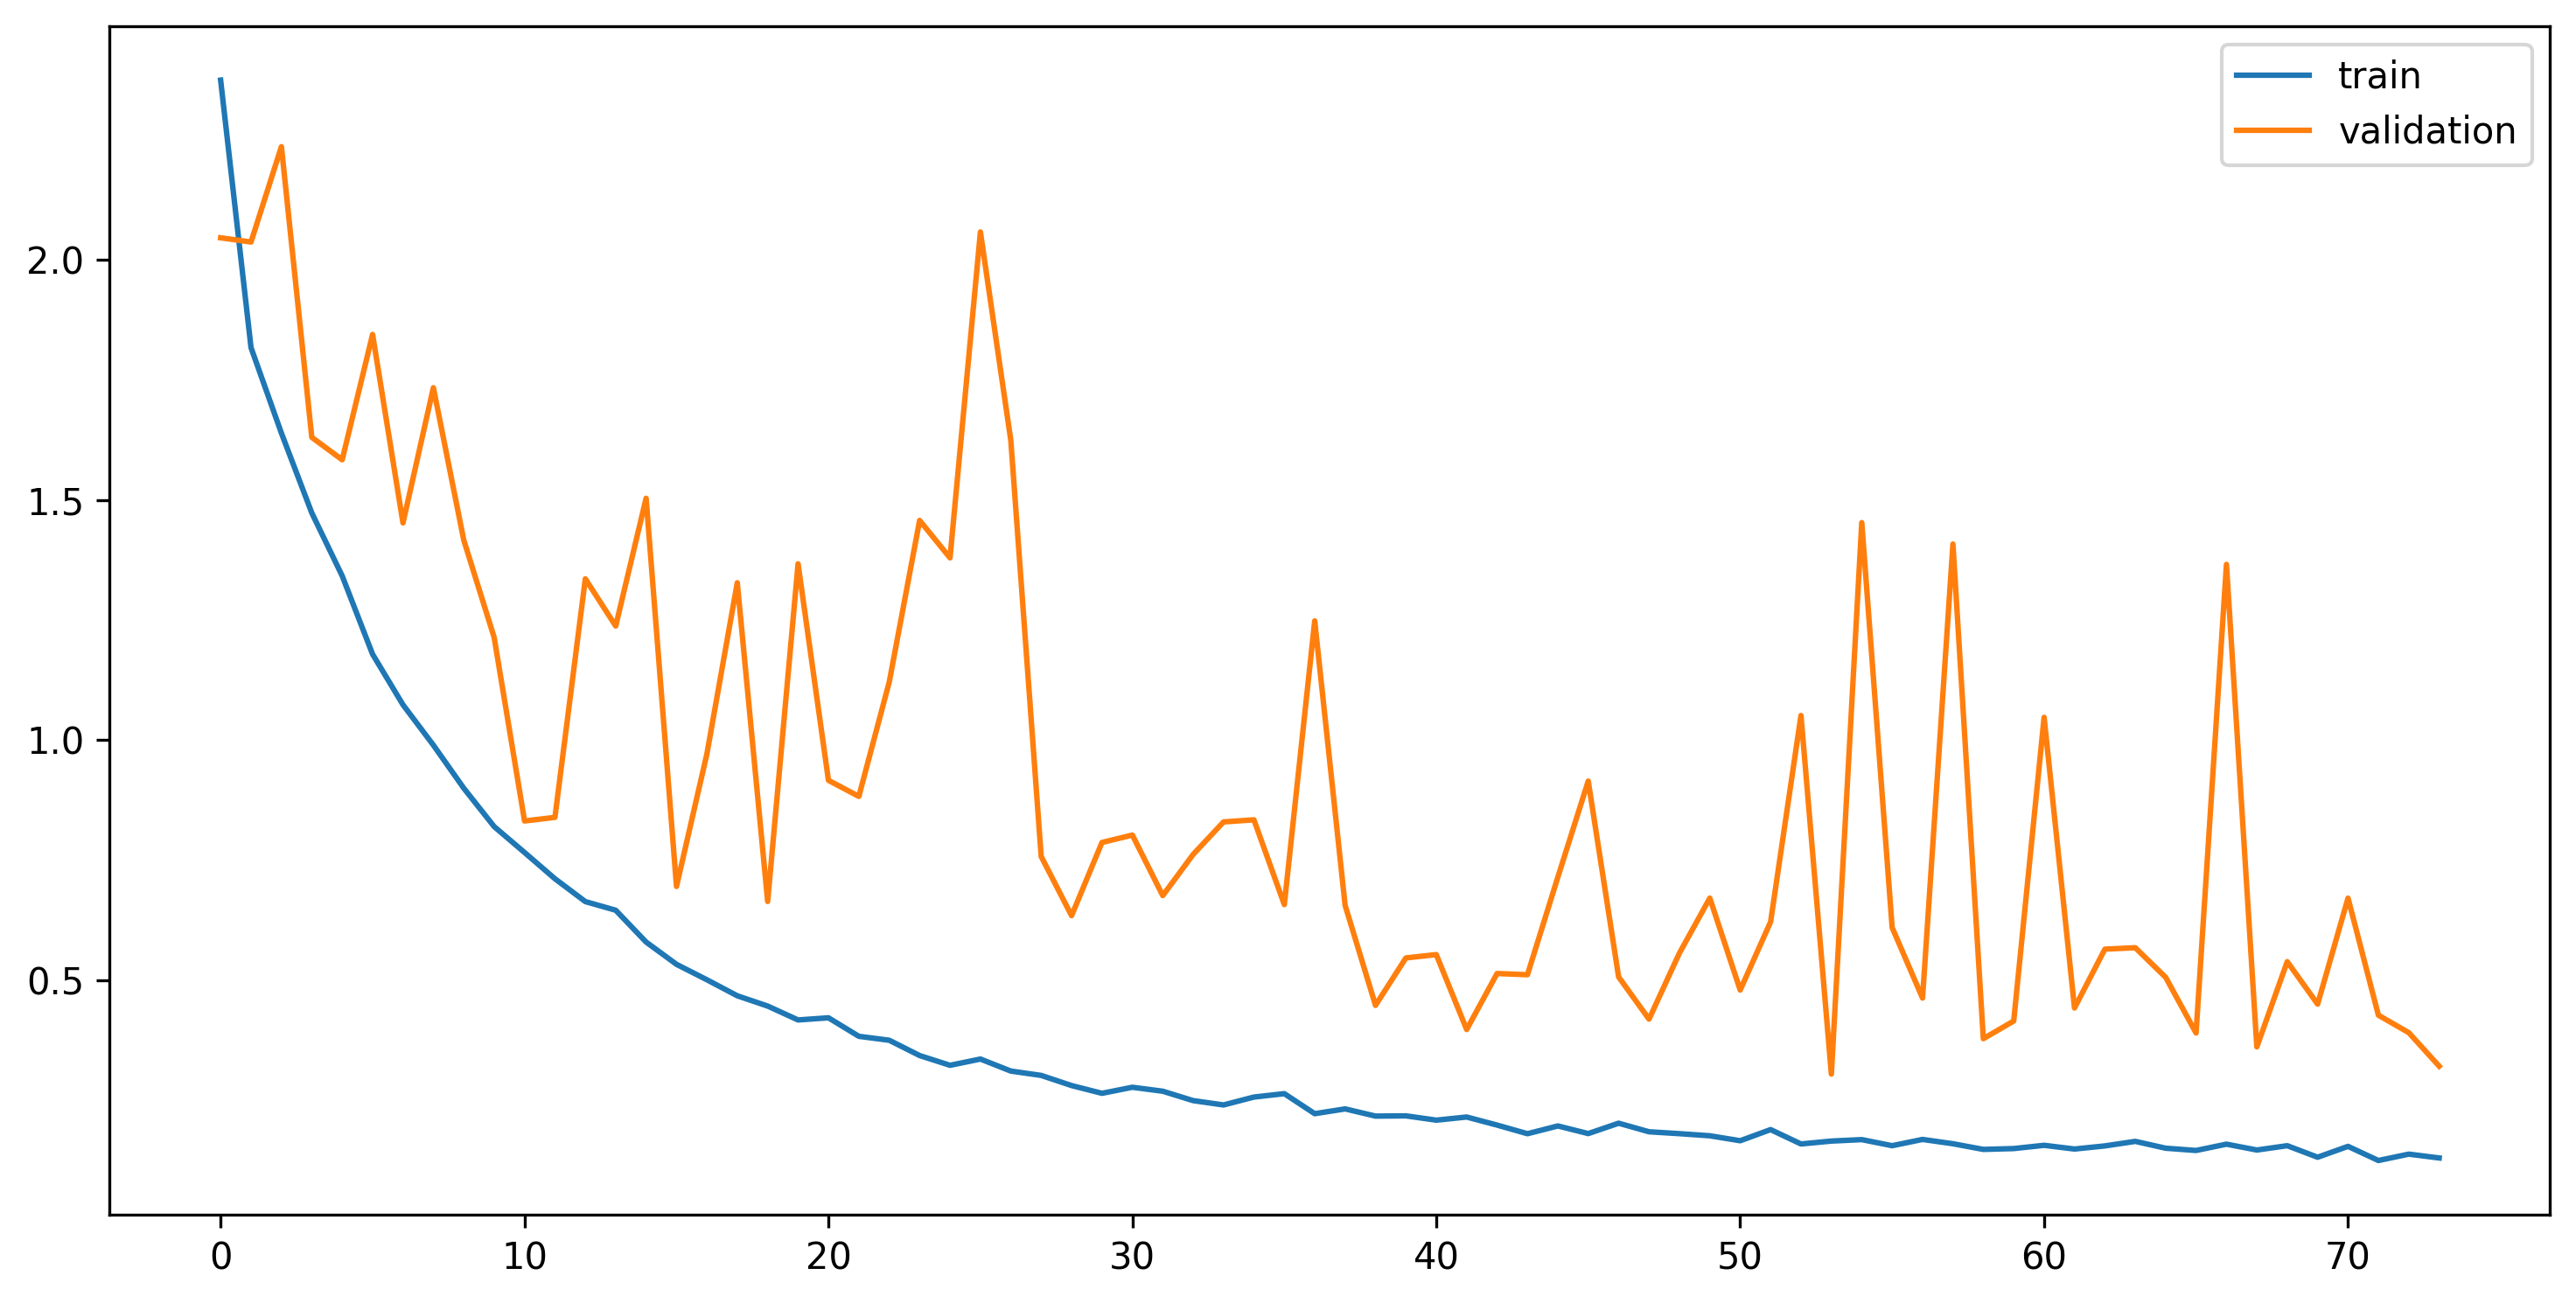

In [12]:
plt.figure(figsize=[12,6], dpi=300)
sns.lineplot(x=list(range(len(history.history['main_out_loss']))),
             y=history.history['main_out_loss'],
             label='train')
sns.lineplot(x=list(range(len(history.history['val_main_out_loss']))),
             y=history.history['val_main_out_loss'],
             label='validation')
plt.show()

In [13]:
print(f'train score : {model.evaluate(train_data)} -- validation : {model.evaluate(valid_data)}')

65/65 [==============================] - 37s 561ms/step - loss: 0.4936 - main_out_loss: 0.2966 - aux_out1_loss: 0.3434 - aux_out2_loss: 0.3131 - main_out_accuracy: 0.9206 - aux_out1_accuracy: 0.8984 - aux_out2_accuracy: 0.9090
train score : [0.23422905802726746, 0.13318733870983124, 0.18975624442100525, 0.14704957604408264, 0.9591836929321289, 0.9375750422477722, 0.9521008133888245] -- validation : [0.4935688376426697, 0.2966335713863373, 0.3433961570262909, 0.3130545914173126, 0.920558512210846, 0.8984111547470093, 0.9090033769607544]


### Saving files

In [14]:
temp = pd.DataFrame(history.history)
temp.to_csv('model_inc_history.csv', index=False)

In [15]:
model.save('model.hdf5')

In [16]:
model.save_weights('model_inception_weights.hdf5')

### Inference

In [17]:
train_data.class_indices

{'bacterial_leaf_blight': 0,
 'bacterial_leaf_streak': 1,
 'bacterial_panicle_blight': 2,
 'blast': 3,
 'brown_spot': 4,
 'dead_heart': 5,
 'downy_mildew': 6,
 'hispa': 7,
 'normal': 8,
 'tungro': 9}

In [18]:
test_preds = []

for i, file in enumerate(os.listdir('../input/paddy-disease-classification/test_images')):
    img = load_img(os.path.join('../input/paddy-disease-classification/test_images',file), target_size=(input_size,input_size))
    pred = model.predict(np.expand_dims(img_to_array(img)/255.0, axis=0))
    pred = np.argmax(pred[0][0])
    label = list(train_data.class_indices.keys())[list(train_data.class_indices.values()).index(pred)]
    test_preds.append([file, label])
    print(f"{i+1}/{len(os.listdir('../input/paddy-disease-classification/test_images'))}", end='\r')

In [19]:
temp = pd.DataFrame(test_preds, columns=['image_id', 'label'])
temp.to_csv('model_submission.csv', index=False)
temp

,image_id,label
0,200607.jpg,normal
1,202733.jpg,normal
2,200207.jpg,bacterial_leaf_streak
3,203024.jpg,tungro
4,203056.jpg,hispa
...,...,...
3464,203316.jpg,tungro
3465,201462.jpg,downy_mildew
3466,200426.jpg,dead_heart
3467,202213.jpg,downy_mildew
